<a href="https://colab.research.google.com/github/kaggle-team/IEEE-Fraud-Detection/blob/master/categorical_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
'''Loading data from Google Drive'''

from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
import pandas as pd
import numpy as np

# For graphs
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style
style.use('ggplot') #seaborn

In [0]:
!unzip -q "/content/gdrive/My Drive/Kaggle/IEEE-Fraud-Detection.zip"
files_path = "/content/"
train_identity_path = os.path.join(files_path, 'train_identity.csv')
train_transaction_path = os.path.join(files_path, 'train_transaction.csv')
test_identity_path = os.path.join(files_path, 'test_identity.csv')
test_transaction_path = os.path.join(files_path, 'test_transaction.csv')

In [0]:
train_identity = pd.read_csv(train_identity_path)
train_transaction = pd.read_csv(train_transaction_path)

In [0]:
train = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
del train_identity, train_transaction

In [0]:
# Reduce memory by changing type of column without NaN
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings            
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()            
            
            if np.isfinite(df[col]).all(): 
                
              # test if column can be converted to an integer
              asint = df[col].fillna(0).astype(np.int64)
              result = (df[col] - asint)
              result = result.sum()
              if result > -0.01 and result < 0.01:
                  IsInt = True            
              # Make Integer/unsigned Integer datatypes
              if IsInt:
                  if mn >= 0:
                      if mx < 255:
                          df[col] = df[col].astype(np.uint8)
                      elif mx < 65535:
                          df[col] = df[col].astype(np.uint16)
                      elif mx < 4294967295:
                          df[col] = df[col].astype(np.uint32)
                      else:
                          df[col] = df[col].astype(np.uint64)
                  else:
                      if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                          df[col] = df[col].astype(np.int8)
                      elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                          df[col] = df[col].astype(np.int16)
                      elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                          df[col] = df[col].astype(np.int32)
                      elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                          df[col] = df[col].astype(np.int64)    
              # Make float datatypes 32 bit
              else:
                  df[col] = df[col].astype(np.float32)

    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",np.round(100*mem_usg/start_mem_usg,2),"% of the initial size")

    return df

In [9]:
train = reduce_mem_usage(train)

Memory usage of properties dataframe is : 1959.8762512207031  MB
Memory usage is:  1897.3629570007324  MB
This is  96.8103448275862 % of the initial size


In [0]:
categoricals = train.select_dtypes(include = 'object').columns.values.tolist()
len(categoricals)
quantitative = [x for x in train.columns if not x in categoricals]

In [0]:
#on considere NaN comme un label, pour voir si même les missing values peuvent avoir un intérêt
train[categoricals] = train[categoricals].fillna('NaN')

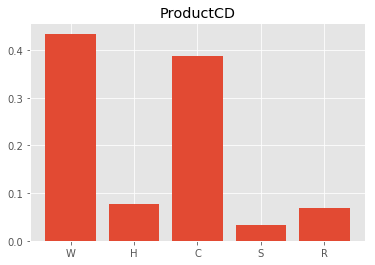

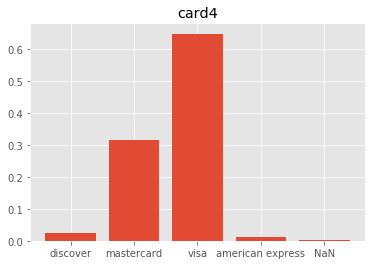

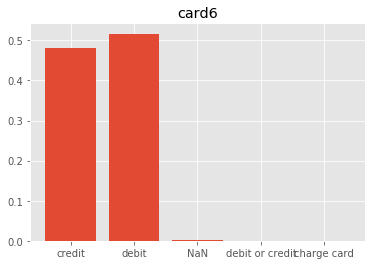

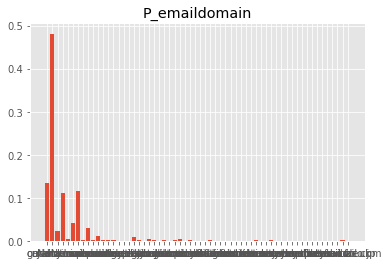

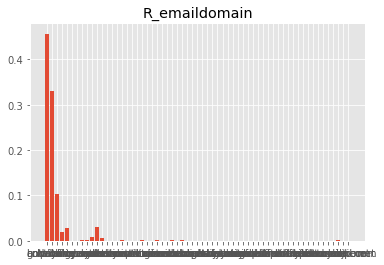

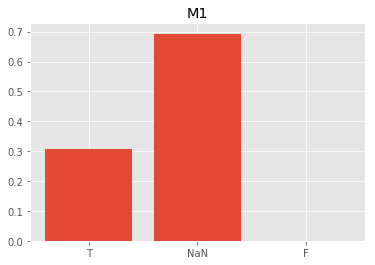

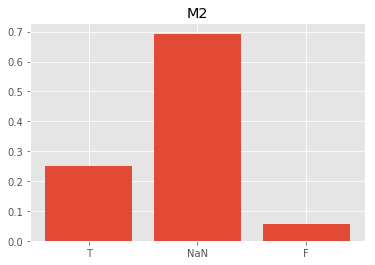

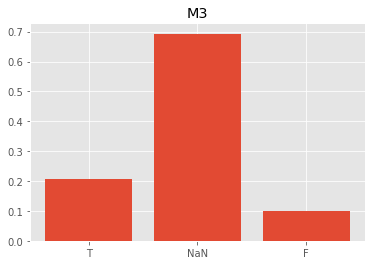

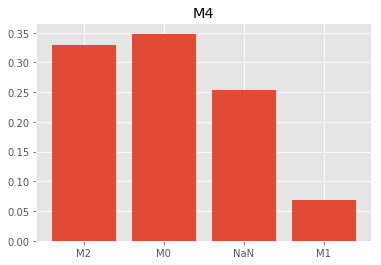

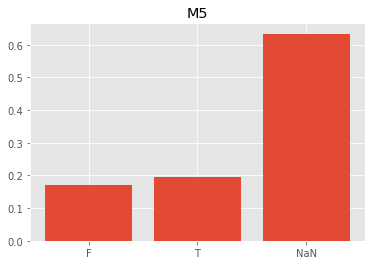

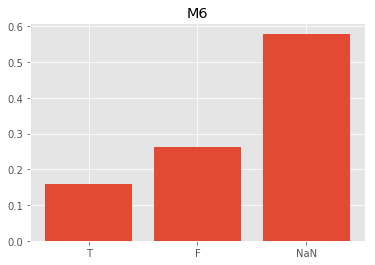

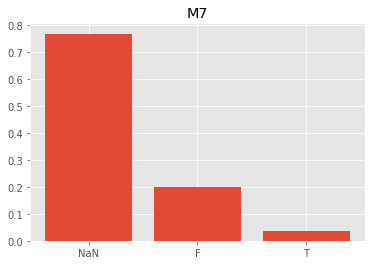

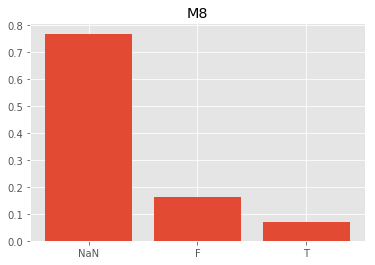

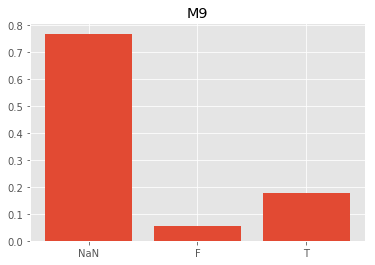

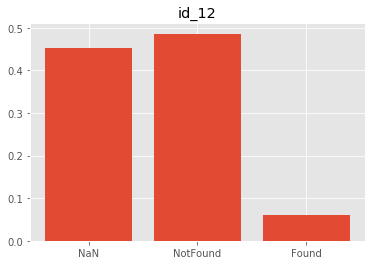

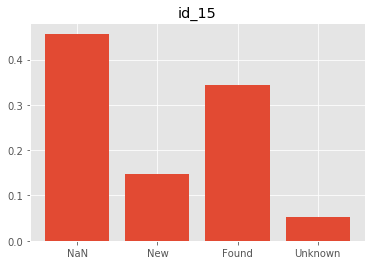

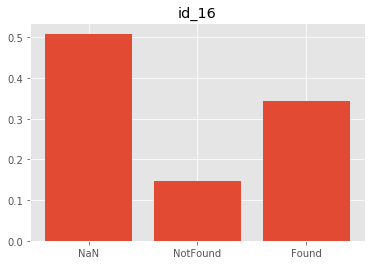

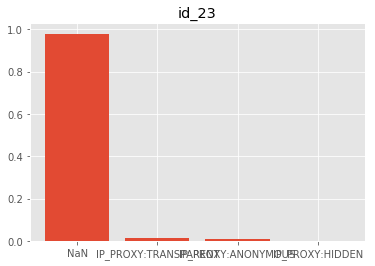

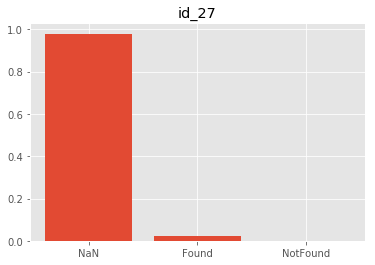

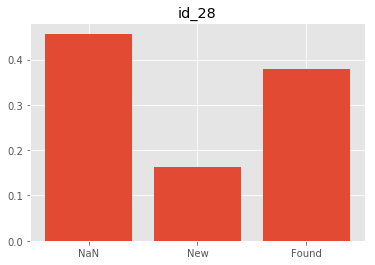

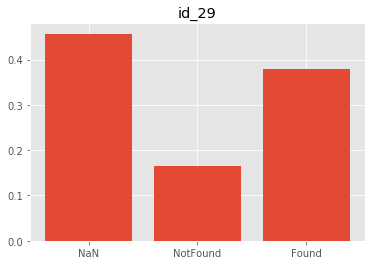

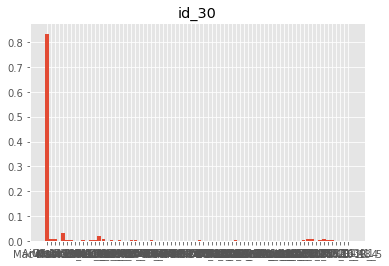

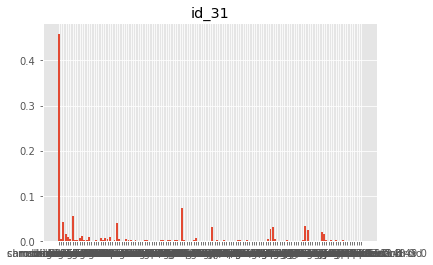

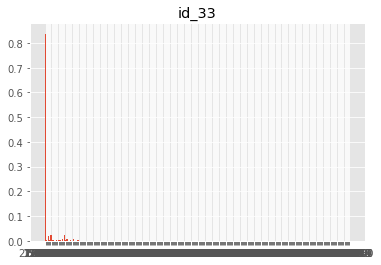

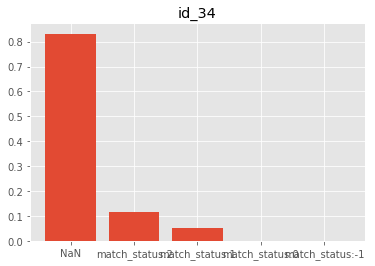

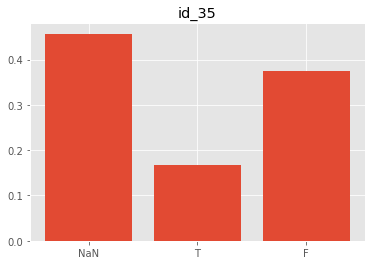

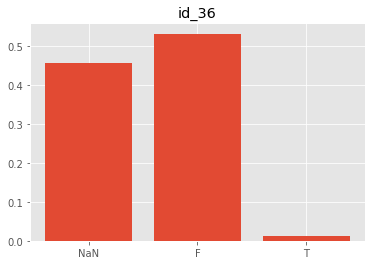

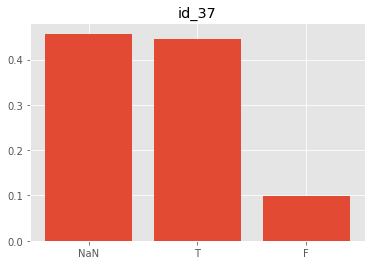

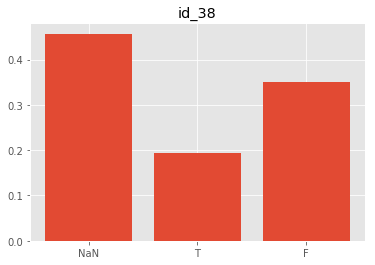

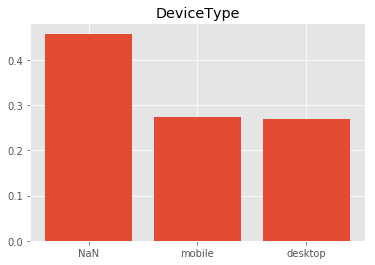

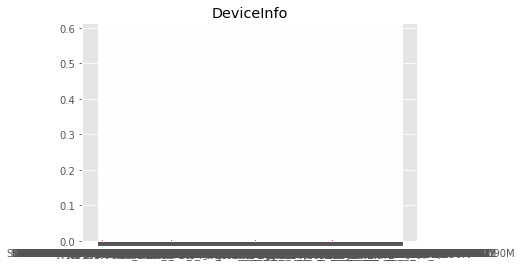

In [35]:
few_labels = train[categoricals].nunique()[train[categoricals].nunique() <6].keys()
many_labels = [elt for elt in categoricals if not elt in few_labels]
proportions = []
for col in categoricals:
  proportions = []
  for elt in train[col].unique():
    proportions.append(train[(train[col]==elt) & (train['isFraud'] == 1)].shape[0]/train[train['isFraud']==1].shape[0])
  fig = plt.figure()

  plt.bar(x= np.arange(len(proportions)), height = proportions, tick_label=train[col].unique().tolist())

  plt.title(col)
  plt.show() 

**Au vu des resultats on peut:**
- ProductCD: ajouter dummy "is in H,S,R"
- card4: ajouter dummy "is in discover, american xprs, NaN"
- card6: ajouter dummy "is in NaN, dbt or crdt, charge card"
- M1, M2,M3: ajouter dummy "is in discover, F" ou "is in T,F"

- Que veut dire M4?

- M5, M6,M7,M8,M9: dummy pour T et F?
  
- id_12: ajouter dummy "is in found"
- id_15: ajouter dummy "is in new, unknown"
- id_16: ajouter dummy "is in new, notfound"
- id_23, id_27, id_34: ajouter dummy "is NaN"
- id_28: ajouter dummy "is new"
- id_29: ajouter dummy "is notfound"
- id_35 id_36: ajouter dummy "is T"
- id_37: ajouter dummy "is F"
  

In [0]:
# Check if a label is in test file but not in train

In [0]:
test_identity = pd.read_csv(test_identity_path)
test_transaction = pd.read_csv(test_transaction_path)
test = pd.merge(test_transaction, test_identity, on='TransactionID', how='left')
del test_identity, test_transaction

test = reduce_mem_usage(test)
test[[x for x in categoricals if not x=='IsFraud']] = test[[x for x in categoricals if not x=='IsFraud']].fillna('NaN')

In [37]:
for elt in [x for x in categoricals if not x=='IsFraud']:
  tmp = train[elt].unique()
  tmp2 = test[elt].unique()
  new = [y for y in tmp2 if not y in tmp]
  if len(new) > 0:
    print(elt,'\t', len(new), 'new labels\n', new)

P_emaildomain 	 1 new labels
 ['scranton.edu']
id_30 	 12 new labels
 ['Android 9', 'iOS 12.0.0', 'Mac OS X 10_13_6', 'Mac OS X 10.14', 'Mac OS X 10_14_0', 'Mac OS X 10_14', 'iOS 12.1.0', 'Mac OS X 10_14_1', 'iOS 12.0.1', 'iOS 12.1.1', 'Mac OS X 10_14_2', 'iOS 12.1.2']
id_31 	 42 new labels
 ['firefox 61.0', 'samsung browser 7.2', 'chrome 67.0 for ios', 'google search application 52.0', 'firefox 62.0', 'mobile safari 12.0', 'chrome 68.0', 'opera 54.0', 'firefox mobile 62.0', 'google search application 54.0', 'safari 12.0', 'chrome 68.0 for android', 'chrome 68.0 for ios', 'chrome 39.0 for android', 'chrome 70.0', 'rim', 'chrome 69.0 for android', 'google search application 56.0', 'samsung browser 7.4', 'opera 55.0', 'firefox 63.0', 'google search application 58.0', 'chrome 69.0 for ios', 'chrome 70.0 for android', 'uc', 'google search application 59.0', 'opera 56.0', 'chrome 71.0', 'google search application 60.0', 'edge 18.0', 'chrome 70.0 for ios', 'firefox mobile 63.0', 'google sear